In [1]:
import numpy as np
import pandas as pd
import ast
from sentence_transformers import util
import matplotlib.pyplot as plt
from itertools import chain
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import ast
from sentence_transformers import util
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
expunations = pd.read_csv('expunations_complete_with_score_generated_pairs_minilm_openai_embeddings.csv', encoding='utf-8')


In [3]:
expunations

,ID,explanation,keywords,joke,funniness_average,filtered_funniness_average,expression1,expression2,sentence1,sentence2,emb_openai_joke,emb_openai_expression1,emb_openai_expression2,emb_openai_sentence1,emb_openai_sentence2,emb_minilm_joke,emb_minilm_expression1,emb_minilm_expression2,emb_minilm_sentence1,emb_minilm_sentence2
0,hom_657,['the phrase dish it out means to criticizie a...,"[[""waitress's"", 'dish it out'], [''], [''], ['...",She was only a Waitress ' s daughter but she s...,0.6,1.000000,dish it out,dish it out,The waitress had to dish it out to all the cus...,"During the feedback session, she was able to d...","[0.030972516164183617, -0.01517175231128931, -...","[0.014902290888130665, -0.03285151720046997, -...","[0.014902290888130665, -0.03285151720046997, -...","[0.005138686392456293, -0.007233967538923025, ...","[0.010029598139226437, -0.009848949499428272, ...","[-0.03195299953222275, -0.005314176436513662, ...","[0.02359960786998272, 0.10548564046621323, -0....","[0.02359960786998272, 0.10548564046621323, -0....","[-0.03609524294734001, 0.055144697427749634, 0...","[0.0027361176908016205, 0.02424769103527069, -..."
1,het_1635,"['', 'This is a play on words. The words ""pane...","[[''], ['glazier', 'window', 'feel your pane',...",When the glazier was sent to the hospital room...,1.2,2.000000,pane,pain,The glazier carefully installed the new pane i...,The patient experienced severe pain after the ...,"[-0.01962309144437313, 0.04074713587760925, -0...","[0.027517514303326607, -0.026580538600683212, ...","[0.014019208028912544, -0.012372410856187344, ...","[-0.03295952454209328, 0.04716017097234726, -0...","[-0.03114989958703518, 0.02944694459438324, -0...","[-0.07717575877904892, 0.03188902512192726, 0....","[-0.008362654596567154, 0.006861681118607521, ...","[-0.06583624333143234, 0.005977192427963018, 0...","[0.038147103041410446, -0.005319848190993071, ...","[0.011634974740445614, 0.03996971994638443, -0..."
2,hom_1510,"['sandpaper is normally rough on one side ', '...","[['inventor', 'sandpaper', 'rough'], ['invento...",The inventor of sandpaper had a rough time of ...,1.6,1.600000,rough,rough,He had a rough day dealing with the challenges.,The sandpaper is rough and scratches the surface.,"[0.01849677972495556, 0.016096102073788643, 0....","[-0.02635161764919758, 0.004799611866474152, 0...","[-0.02635161764919758, 0.004799611866474152, 0...","[-0.026946933940052986, -0.001050555962137878,...","[0.004222436808049679, 0.02058914303779602, 0....","[-0.028803806751966476, 0.06886464357376099, 0...","[-0.020329659804701805, -0.012983807362616062,...","[-0.020329659804701805, -0.012983807362616062,...","[0.04728022962808609, 0.13506457209587097, 0.0...","[-0.010853069834411144, -0.0011316132731735706..."
3,hom_955,"['', '', '', 'A contortionist is someone who c...","[[''], [''], [''], ['contortionists', 'die', '...","OLD CONTORTIONISTS never die , they just meet ...",0.2,1.000000,meet their end,meet their end,Everyone will meet their end eventually.,The contortionist could effortlessly meet thei...,"[0.05470442399382591, 0.028842754662036896, 0....","[0.046937935054302216, 0.020673619583249092, 0...","[0.046937935054302216, 0.020673619583249092, 0...","[0.02289336919784546, 0.019332490861415863, 0....","[0.04577306658029556, 0.008717942051589489, 0....","[-0.008412803523242474, -0.04027313366532326, ...","[-0.04347410425543785, 0.022733362391591072, 0...","[-0.04347410425543785, 0.022733362391591072, 0...","[-0.022082282230257988, -0.03496827557682991, ...","[-0.05765708535909653, 0.005961173679679632, -..."
4,hom_1505,"['', 'This is a play on words. The word ""party...","[[''], ['whose place to have a party at', 'par...",When you can ' t decide with your friends whos...,0.4,0.666667,party,party,We are hosting a party at our home this Saturday.,The Liberal party announced its new policy age...,"[0.020545732229948044, -0.01821220852434635, 0...","[0.016281891614198685, -0.004896087571978569, ...","[0.01626163721084

In [7]:
for i in range (100):
    print (expunations.iloc[i]['joke'])

She was only a Waitress ' s daughter but she sure could dish it out .
When the glazier was sent to the hospital room to check the cracked window , he told the patient in the body cast , ' ' I ' ve come to feel your pane . ' '
The inventor of sandpaper had a rough time of it .
OLD CONTORTIONISTS never die , they just meet their end .
When you can ' t decide with your friends whose place to have a party at it ' s known as party politics .
Back when the news was written on clay tablets there was a lot of breaking news .
My friend came around for dinner . We ate for 20 minutes , then he fainted again .
A band of teenagers cruised past my neighbor ' s house and pelted it with rotten tomatoes . Police described it as a drive - by fruiting .
None but the brave deserve the fair .
Romance isn ' t a science - it ' s a heart .
OLD STATUES never die they just get busted .
Actors are cast through their good and bad stages .
Patience is a virtue heavy in wait
OLD POLICEMEN never die they just cop ou

# Create classes

In [22]:
import ast
from statistics import mode

expunations['average_score_approx'] = 0


In [23]:
expunations['average_score_approx'] = expunations['funniness_average'].round().astype(int)


In [24]:
expunations['average_score_approx'] = expunations['average_score_approx'].replace(3, 2)


In [25]:
# Check the distribution of classes in y_train
class_counts = expunations['average_score_approx'].value_counts()
print(class_counts)

average_score_approx
1    944
2    573
0    373
Name: count, dtype: int64


# Four metrics:

    • Obviousness: the cosine similarity of the embedding vectors of X (“sex”) and Z (“with body cams”).
    • Compatibility: the cosine similarity of the embedding vectors of Y (“police officers” and Z (“with body cams”).
    • Symmetry: the difference between obviousness and compatibility.
    • Comparison: the cosine similarity of the embedding vectors of XZ (“sex with body cams”) and YZ (police officers with body cams”).

# MINILM

In [26]:
# Obviousness

expunations['minilm_obviousness'] = None
expunations['minilm_obviousness'] = expunations.apply(
    lambda row: abs(
        util.cos_sim(ast.literal_eval(row['emb_minilm_expression1']), ast.literal_eval(row['emb_minilm_sentence1'])).item()
    ),
    axis=1
)

In [27]:
# Compatibility

expunations['minilm_compatibility'] = None
expunations['minilm_compatibility'] = expunations.apply(
    lambda row: abs(
        util.cos_sim(ast.literal_eval(row['emb_minilm_expression2']), ast.literal_eval(row['emb_minilm_sentence2'])).item()
    ),
    axis=1
)

In [28]:
# Symmetry

expunations['minilm_symmetry'] = None
expunations['minilm_symmetry'] = expunations['minilm_obviousness'] - expunations['minilm_compatibility']

In [29]:
# Comparison

expunations['minilm_comparison'] = None
expunations['minilm_comparison'] = expunations.apply(
    lambda row: abs(
        util.cos_sim(ast.literal_eval(row['emb_minilm_joke']), ast.literal_eval(row['emb_minilm_sentence1'])).item() -
        util.cos_sim(ast.literal_eval(row['emb_minilm_joke']), ast.literal_eval(row['emb_minilm_sentence2'])).item()
    ),
    axis=1
)

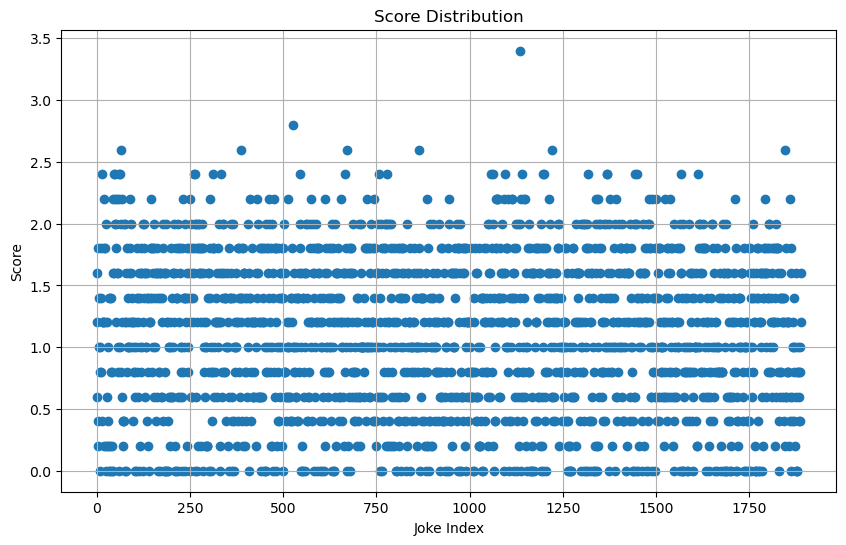

In [30]:
import matplotlib.pyplot as plt

# Plot the score values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(expunations['minilm_obviousness'])),expunations['funniness_average'])
plt.title('Score Distribution')
plt.xlabel('Joke Index')
plt.ylabel('Score')
#plt.ylim(0, 100)  # Set Y-axis range from 0 to 10
#plt.yscale('log')
plt.grid(True)
plt.show()


# Regression

In [31]:
subset_df = expunations[['minilm_symmetry', 'minilm_compatibility', 'minilm_obviousness', 'minilm_comparison', 'funniness_average']].copy()
data = subset_df[['minilm_symmetry', 'minilm_compatibility', 'minilm_obviousness', 'minilm_comparison']] #0.615 0.628
target = subset_df['funniness_average']
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=40)


# Create and train the model
model = LinearRegression()
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(x_test)

# Evaluation
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))


Coefficients: [0.12063705 0.01014082 0.13077787 0.29128576]
Intercept: 0.9696954267578296
Mean squared error: 0.4052302504888069
R² score: -0.009793606186792037


# Random forest

In [32]:
def metrics (y_true, y_predicted):
    accuracy = accuracy_score(y_true, y_predicted)
    print("Accuracy: ", accuracy)
    precision = precision_score(y_true, y_predicted, average='weighted')
    print("Précision: ", precision)
    recall = recall_score(y_true, y_predicted, average='weighted')
    print("Recall: ", recall)
    f1 = f1_score(y_true, y_predicted, average='weighted')
    print("F1-score: ", f1)
    conf_mat = confusion_matrix(y_true, y_predicted, normalize='all')
    print("Confusion matrix :\n", conf_mat)


In [34]:
subset_df = expunations[['minilm_symmetry', 'minilm_compatibility', 'minilm_obviousness', 'minilm_comparison', 'average_score_approx']].copy()
data = subset_df[['minilm_symmetry', 'minilm_compatibility', 'minilm_obviousness', 'minilm_comparison']]
target = subset_df['average_score_approx']
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=40)




# Define the classifier
clf = RandomForestClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50, 100, 200, 300],           # number of trees
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],          # None means full depth
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],      # minimum samples to split a node
}

# Setup grid search with 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# Use the optimized model
clf = grid_search.best_estimator_






# Create and train the random forest (depth determined automatically)
#clf = RandomForestClassifier(max_depth=5)  # n_estimators is number of trees
clf.fit(x_train, y_train)

# Plot one of the trees in the forest for visualization
plt.figure(figsize=(20,10))
plot_tree(clf.estimators_[0], filled=True)  # Plot the first tree in the ensemble
plt.show()



y_pred_train = clf.predict(x_train)
metrics(y_train, y_pred_train)
print()
y_pred_test = clf.predict(x_test)
metrics(y_test, y_pred_test)

KeyboardInterrupt: 

# SVM

In [35]:
subset_df = expunations[['minilm_symmetry', 'minilm_compatibility', 'minilm_obviousness', 'minilm_comparison', 'average_score_approx']].copy()
data = subset_df[['minilm_symmetry', 'minilm_compatibility', 'minilm_obviousness', 'minilm_comparison']]
target = subset_df['average_score_approx']
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=40)


from sklearn import svm
clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(x_train, y_train)
plt.show()

y_pred_train = clf.predict(x_train)
metrics(y_train, y_pred_train)
print()
y_pred_test = clf.predict(x_test)
metrics(y_test, y_pred_test)




Accuracy:  0.4966931216931217
Précision:  0.24670405713725818
Recall:  0.4966931216931217
F1-score:  0.32966551868452
Confusion matrix :
 [[0.         0.19973545 0.        ]
 [0.         0.49669312 0.        ]
 [0.         0.30357143 0.        ]]

Accuracy:  0.5105820105820106
Précision:  0.26069398952996836
Recall:  0.5105820105820106
F1-score:  0.3451570159100807
Confusion matrix :
 [[0.         0.18783069 0.        ]
 [0.         0.51058201 0.        ]
 [0.         0.3015873  0.        ]]


/opt/miniconda3/envs/humour/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/humour/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train, y_train)
plt.show()

y_pred_train = clf.predict(x_train)
metrics(y_train, y_pred_train)
print()
y_pred_test = clf.predict(x_test)
metrics(y_test, y_pred_test)



# OPENAI

In [ ]:
# Obviousness

expunations['openai_obviousness'] = None
expunations['openai_obviousness'] = expunations.apply(
    lambda row: abs(
        util.cos_sim(ast.literal_eval(row['emb_openai_expression1']), ast.literal_eval(row['emb_openai_sentence1'])).item()
    ),
    axis=1
)

# Compatibility

expunations['openai_compatibility'] = None
expunations['openai_compatibility'] = expunations.apply(
    lambda row: abs(
        util.cos_sim(ast.literal_eval(row['emb_openai_expression2']), ast.literal_eval(row['emb_openai_sentence2'])).item()
    ),
    axis=1
)

# Symmetry

expunations['openai_symmetry'] = None
expunations['openai_symmetry'] = expunations['openai_obviousness'] - expunations['openai_compatibility']

# Comparison

expunations['openai_comparison'] = None
expunations['openai_comparison'] = expunations.apply(
    lambda row: abs(
        util.cos_sim(ast.literal_eval(row['emb_openai_joke']), ast.literal_eval(row['emb_openai_sentence1'])).item() -
        util.cos_sim(ast.literal_eval(row['emb_openai_joke']), ast.literal_eval(row['emb_openai_sentence2'])).item()
    ),
    axis=1
)

# Regression

In [ ]:
subset_df = expunations[['openai_symmetry', 'openai_compatibility', 'openai_obviousness', 'openai_comparison', 'funniness_average']].copy()
data = subset_df[['openai_symmetry', 'openai_compatibility', 'openai_obviousness', 'openai_comparison']] #0.615 0.628
target = subset_df['funniness_average']
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=40)


# Create and train the model
model = LinearRegression()
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(x_test)

# Evaluation
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))


# Random forest

In [ ]:
subset_df = expunations[['openai_symmetry', 'openai_compatibility', 'openai_obviousness', 'openai_comparison', 'average_score_approx']].copy()
data = subset_df[['openai_symmetry', 'openai_compatibility', 'openai_obviousness', 'openai_comparison']] #0.615 0.628
target = subset_df['average_score_approx']
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=40)




# Define the classifier
clf = RandomForestClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50, 100, 200, 300],           # number of trees
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],          # None means full depth
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],      # minimum samples to split a node
}

# Setup grid search with 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# Use the optimized model
clf = grid_search.best_estimator_






# Create and train the random forest (depth determined automatically)
#clf = RandomForestClassifier(max_depth=5)  # n_estimators is number of trees
clf.fit(x_train, y_train)

# Plot one of the trees in the forest for visualization
plt.figure(figsize=(20,10))
plot_tree(clf.estimators_[0], filled=True)  # Plot the first tree in the ensemble
plt.show()



y_pred_train = clf.predict(x_train)
metrics(y_train, y_pred_train)
print()
y_pred_test = clf.predict(x_test)
metrics(y_test, y_pred_test)

# SVM

In [37]:
from sklearn import svm
clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(x_train, y_train)
plt.show()

y_pred_train = clf.predict(x_train)
metrics(y_train, y_pred_train)
print()
y_pred_test = clf.predict(x_test)
metrics(y_test, y_pred_test)




KeyError: "['openai_symmetry', 'openai_compatibility', 'openai_obviousness', 'openai_comparison'] not in index"

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train, y_train)
plt.show()

y_pred_train = clf.predict(x_train)
metrics(y_train, y_pred_train)
print()
y_pred_test = clf.predict(x_test)
metrics(y_test, y_pred_test)

